In [1]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]"

In [2]:
import os
import shutil
import tempfile
import glob
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import monai


from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.data import decollate_batch, partition_dataset_classes, NibabelReader, DataLoader, Dataset
from monai.networks.nets import DenseNet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    Resize,
    ResizeWithPadOrCropd,
    ScaleIntensity,
    ToTensor,
    Activations,
    AsDiscrete,
    EnsureType,
    Pad,
    SpatialCrop,
    CenterSpatialCrop
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.0.1
Numpy version: 1.21.6
Pytorch version: 1.13.0+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.0+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
set_determinism(seed=0)

In [4]:
!nvidia-smi

Tue Dec 13 03:33:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.getcwd()

'/content'

In [7]:
data_dir = '/content/drive/MyDrive/02718 Project/Dataset/nifti'

# csv

In [8]:
mgmt_df = pd.read_csv('/content/drive/MyDrive/02718 Project/Dataset/mgmt_df_for_image_cls.csv' )

In [9]:
mgmt_df.columns

Index(['ID', 'Age at MRI', 'WHO CNS Grade', 'MGMT index', '1-dead 0-alive',
       'OS', 'Sex_F', 'Final pathologic diagnosis_Astrocytoma, IDH-mutant',
       'Final pathologic diagnosis_Astrocytoma, IDH-wildtype',
       'Final pathologic diagnosis_Glioblastoma, IDH-wildtype',
       'Final pathologic diagnosis_Oligodendroglioma, IDH-mutant, 1p/19q-codeleted',
       'MGMT status_indeterminate', 'MGMT status_negative',
       'MGMT status_positive', 'MGMT status_nan', '1p/19q_co-deletion',
       '1p/19q_intact', '1p/19q_relative co-deletion', '1p/19q_nan',
       'IDH_IDH1 p.Arg132His', 'IDH_IDH1 p.R132C', 'IDH_IDH1 p.R132G',
       'IDH_IDH1 p.R132H', 'IDH_IDH1 p.R132S', 'IDH_IDH2 p.Arg172Trp',
       'IDH_IDH2 p.R172K', 'IDH_mutated (NOS)', 'IDH_wildtype', 'EOR_GTR',
       'EOR_STR', 'EOR_biopsy', 'EOR_nan', 'biopsy_No', 'biopsy_Yes'],
      dtype='object')

In [10]:
mgmt_df[['ID', 'MGMT status_negative',
       'MGMT status_positive']]

,ID,MGMT status_negative,MGMT status_positive
0,UCSF-PDGM-004,1,0
1,UCSF-PDGM-008,1,0
2,UCSF-PDGM-009,1,0
3,UCSF-PDGM-010,0,1
4,UCSF-PDGM-011,0,1
...,...,...,...
410,UCSF-PDGM-537,0,1
411,UCSF-PDGM-538,1,0
412,UCSF-PDGM-539,0,1
413,UCSF-PDGM-540,0,1


In [11]:
mgmt_df['MGMT status_positive'] == 1

0      False
1      False
2      False
3       True
4       True
       ...  
410     True
411    False
412     True
413     True
414    False
Name: MGMT status_positive, Length: 415, dtype: bool

In [12]:
mgmt_pos_ids = mgmt_df[mgmt_df['MGMT status_positive'] == 1]['ID'].tolist()
mgmt_neg_ids = mgmt_df[mgmt_df['MGMT status_negative'] == 1]['ID'].tolist()


In [13]:
mgmt_df[['ID', 'MGMT status_negative',
       'MGMT status_positive']]

,ID,MGMT status_negative,MGMT status_positive
0,UCSF-PDGM-004,1,0
1,UCSF-PDGM-008,1,0
2,UCSF-PDGM-009,1,0
3,UCSF-PDGM-010,0,1
4,UCSF-PDGM-011,0,1
...,...,...,...
410,UCSF-PDGM-537,0,1
411,UCSF-PDGM-538,1,0
412,UCSF-PDGM-539,0,1
413,UCSF-PDGM-540,0,1


In [14]:
def create_file_path(id_list, verbose = False):
    
    # add zero to id list
    for i, id in enumerate(id_list):
        id_list[i] = id[:-3] + '0' + id[-3:]

    image_files_list = []
    # add file path
    for i in id_list:
        file = '/' + i +'_T1c.nii.gz' #, recursive = True)
        if verbose:
            print(file)
        image_files_list.append(file)

    return image_files_list

image_pos_file_list = create_file_path(mgmt_pos_ids)
image_neg_file_list = create_file_path(mgmt_neg_ids)

In [15]:
len(image_pos_file_list)

301

In [16]:
len(image_neg_file_list)

114

In [17]:
image_pos_file_list

['/UCSF-PDGM-0010_T1c.nii.gz',
 '/UCSF-PDGM-0011_T1c.nii.gz',
 '/UCSF-PDGM-0013_T1c.nii.gz',
 '/UCSF-PDGM-0014_T1c.nii.gz',
 '/UCSF-PDGM-0016_T1c.nii.gz',
 '/UCSF-PDGM-0018_T1c.nii.gz',
 '/UCSF-PDGM-0019_T1c.nii.gz',
 '/UCSF-PDGM-0021_T1c.nii.gz',
 '/UCSF-PDGM-0022_T1c.nii.gz',
 '/UCSF-PDGM-0023_T1c.nii.gz',
 '/UCSF-PDGM-0024_T1c.nii.gz',
 '/UCSF-PDGM-0025_T1c.nii.gz',
 '/UCSF-PDGM-0026_T1c.nii.gz',
 '/UCSF-PDGM-0030_T1c.nii.gz',
 '/UCSF-PDGM-0031_T1c.nii.gz',
 '/UCSF-PDGM-0033_T1c.nii.gz',
 '/UCSF-PDGM-0035_T1c.nii.gz',
 '/UCSF-PDGM-0036_T1c.nii.gz',
 '/UCSF-PDGM-0037_T1c.nii.gz',
 '/UCSF-PDGM-0038_T1c.nii.gz',
 '/UCSF-PDGM-0039_T1c.nii.gz',
 '/UCSF-PDGM-0040_T1c.nii.gz',
 '/UCSF-PDGM-0043_T1c.nii.gz',
 '/UCSF-PDGM-0044_T1c.nii.gz',
 '/UCSF-PDGM-0045_T1c.nii.gz',
 '/UCSF-PDGM-0047_T1c.nii.gz',
 '/UCSF-PDGM-0048_T1c.nii.gz',
 '/UCSF-PDGM-0049_T1c.nii.gz',
 '/UCSF-PDGM-0050_T1c.nii.gz',
 '/UCSF-PDGM-0053_T1c.nii.gz',
 '/UCSF-PDGM-0055_T1c.nii.gz',
 '/UCSF-PDGM-0056_T1c.nii.gz',
 '/UCSF-

In [18]:
# create full list
image_files_list = image_pos_file_list.copy()
image_files_list.extend(image_neg_file_list)

In [19]:
image_files_list


['/UCSF-PDGM-0010_T1c.nii.gz',
 '/UCSF-PDGM-0011_T1c.nii.gz',
 '/UCSF-PDGM-0013_T1c.nii.gz',
 '/UCSF-PDGM-0014_T1c.nii.gz',
 '/UCSF-PDGM-0016_T1c.nii.gz',
 '/UCSF-PDGM-0018_T1c.nii.gz',
 '/UCSF-PDGM-0019_T1c.nii.gz',
 '/UCSF-PDGM-0021_T1c.nii.gz',
 '/UCSF-PDGM-0022_T1c.nii.gz',
 '/UCSF-PDGM-0023_T1c.nii.gz',
 '/UCSF-PDGM-0024_T1c.nii.gz',
 '/UCSF-PDGM-0025_T1c.nii.gz',
 '/UCSF-PDGM-0026_T1c.nii.gz',
 '/UCSF-PDGM-0030_T1c.nii.gz',
 '/UCSF-PDGM-0031_T1c.nii.gz',
 '/UCSF-PDGM-0033_T1c.nii.gz',
 '/UCSF-PDGM-0035_T1c.nii.gz',
 '/UCSF-PDGM-0036_T1c.nii.gz',
 '/UCSF-PDGM-0037_T1c.nii.gz',
 '/UCSF-PDGM-0038_T1c.nii.gz',
 '/UCSF-PDGM-0039_T1c.nii.gz',
 '/UCSF-PDGM-0040_T1c.nii.gz',
 '/UCSF-PDGM-0043_T1c.nii.gz',
 '/UCSF-PDGM-0044_T1c.nii.gz',
 '/UCSF-PDGM-0045_T1c.nii.gz',
 '/UCSF-PDGM-0047_T1c.nii.gz',
 '/UCSF-PDGM-0048_T1c.nii.gz',
 '/UCSF-PDGM-0049_T1c.nii.gz',
 '/UCSF-PDGM-0050_T1c.nii.gz',
 '/UCSF-PDGM-0053_T1c.nii.gz',
 '/UCSF-PDGM-0055_T1c.nii.gz',
 '/UCSF-PDGM-0056_T1c.nii.gz',
 '/UCSF-

In [20]:
len(image_pos_file_list), len(image_neg_file_list), len(image_files_list)

(301, 114, 415)

In [21]:
data_dir

'/content/drive/MyDrive/02718 Project/Dataset/nifti'

In [22]:
def create_image_class(image_pos_file_list, image_neg_file_list):
    image_pos_class = len(image_pos_file_list) * [1]
    image_neg_class = len(image_neg_file_list) * [0]
    image_class = image_pos_class.copy()
    image_class.extend(image_neg_class)
    return image_class

image_class = create_image_class(image_pos_file_list, image_neg_file_list)

In [23]:
len(image_class), sum(image_class)

(415, 301)

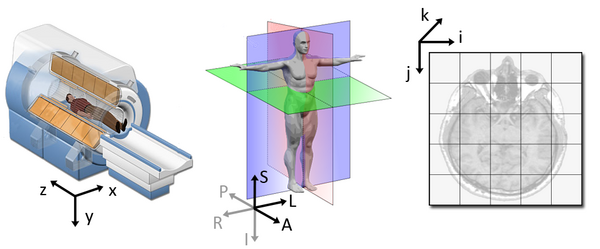

In [24]:
class_names = ['MGMT_negative', 'MGMT_positive']
num_class = len(class_names)

# all T1c file paths
image_files_list
    
num_total = len(image_files_list)
x, y, z = nib.load(data_dir + image_files_list[369]).get_fdata().shape

print(f"Total image count: {num_total}")
print(f"Image dimensions: {x} x {y} x {z}")
print(f"Label names: {class_names}")
# print(f"Label counts: {num_each}")

Total image count: 415
Image dimensions: 240 x 240 x 155
Label names: ['MGMT_negative', 'MGMT_positive']


In [25]:
# sample_nib = nib.load(data_dir + image_files_list[369])

In [26]:
# type(sample_nib)

In [27]:
sample = nib.load(data_dir + image_files_list[369]).get_fdata()


In [28]:
sample.shape

(240, 240, 155)

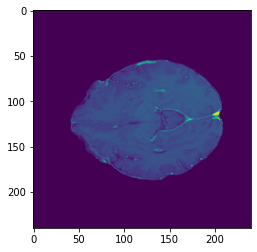

In [29]:
plt.imshow(sample[:, :, 70])

In [30]:
resize = Resize(spatial_size = (256, 256, 64), )

In [31]:
# # pad
pad = Pad(((0,0),(8,8),(8,8),(0,0)), 'constant', constant_values=(0))
# new_sample = pad(sample)
# print('after pad', new_sample.shape)

# # resize
# resize = Resize(spatial_size = (-1, 64))
# new_new_sample = resize(new_sample)
# print('after resize', new_new_sample.shape)

In [32]:
# test

# test transforms

In [33]:
added_c_sample = AddChannel()(sample)

/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [34]:
added_c_sample.shape

(1, 240, 240, 155)

In [35]:
padded_sample = pad(added_c_sample)

In [36]:
padded_sample.shape

(1, 256, 256, 155)

In [37]:
resize2 = Resize(spatial_size = (256,256, 155))

In [38]:
resized_sample = resize2(added_c_sample)

In [39]:
resized_sample.shape

(1, 256, 256, 155)

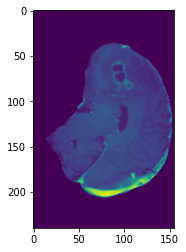

In [40]:
plt.imshow(added_c_sample[0,115, :, : ])


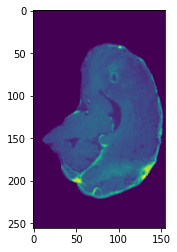

In [41]:
plt.imshow(resized_sample[0,125, :, : ])

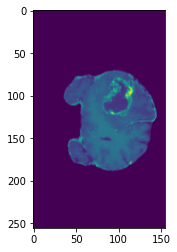

In [42]:
plt.imshow(resized_sample[0,:, 90, : ])

In [43]:
256/2


128.0

In [44]:
spatialcrop = SpatialCrop(roi_center = (128, 128, 77), roi_size = (256, 256, 64))

In [45]:
sc_sample = spatialcrop(resized_sample)

In [46]:
sc_sample.shape

(1, 256, 256, 64)

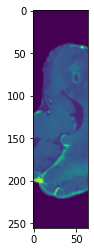

In [47]:
plt.imshow(sc_sample[0,125, :, : ])

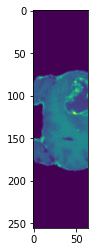

In [48]:
plt.imshow(sc_sample[0,:, 90, : ])

In [49]:
monai.config.print_debug_info()


Printing MONAI config...
MONAI version: 1.0.1
Numpy version: 1.21.6
Pytorch version: 1.13.0+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.0+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies


Printing system config...
System

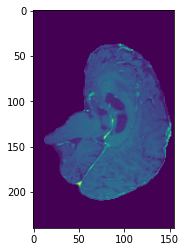

In [50]:
plt.imshow(sample[125, :, : ])

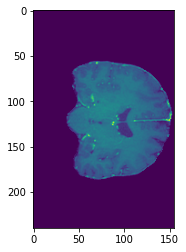

In [51]:
plt.imshow(sample[:,120, :])

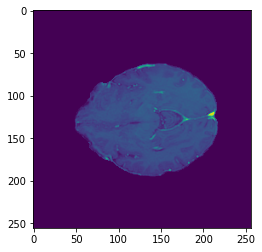

In [52]:
plt.imshow(padded_sample[0,:,:, 70])

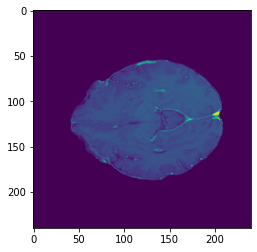

In [53]:
# after pad + resize
plt.imshow(added_c_sample[0,:,:,70])

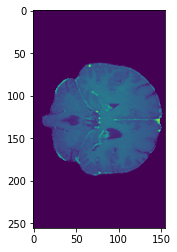

In [54]:
# after pad + resize
plt.imshow(padded_sample[0,:,150,:])

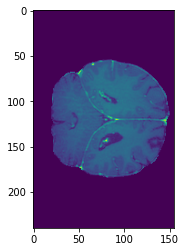

In [55]:
# after pad + resize
plt.imshow(added_c_sample[0,:,150,:])

In [56]:
# after pad + resize
plt.imshow(new_new_sample[150,:,:])

NameError: ignored

# Transform

resize --> [1, 256, 256, 64]

In [57]:
# train_transforms = Compose(
#     [
#         LoadImage(image_only=True),
#         AddChannel(),
#         ScaleIntensity(),
#         RandRotate(range_x=15, prob=0.5, keep_size=True),
#         RandFlip(spatial_axis=0, prob=0.5),
#         RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
     
#         Resize(spatial_size = (256, 256, 64))
#         ToTensor(),
#     ]
# # )

test_transforms = Compose([LoadImage(image_only=True), 
                           AddChannel(), 
                           Pad(to_pad= ((0,0),(8,8),(8,8),(0,0)), mode ='constant', constant_values=(0)), 
                           SpatialCrop(roi_center = (128, 128, 77), roi_size = (256, 256, 64)), 
                           ScaleIntensity(), 
                           ToTensor()])

test_transforms_2 = Compose([LoadImage(image_only=True), 
                           AddChannel(), 
                           Pad(to_pad= ((0,0),(8,8),(8,8),(0,0)), mode ='constant', constant_values=(0)), 
                           SpatialCrop(roi_center = (128, 128, 77), roi_size = (256, 256, 64)), 
                        #    ScaleIntensity(), 
                           ToTensor()])


test_transforms_3 = Compose([LoadImage(image_only=True), 
                           AddChannel(), 
                           Resize(spatial_size = (256,256, 155)), 
                           SpatialCrop(roi_center = (128, 128, 77), roi_size = (256, 256, 64)), 
                           ScaleIntensity(), 
                           ToTensor()])

# act = Compose([EnsureType(), Activations(softmax=True)])
# to_onehot = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=num_class)])

# Reference

https://github.com/Project-MONAI/MONAIBootcamp2021/blob/main/day1/3.%20End-To-End%20Workflow%20with%20MONAI.ipynb 

# Dataset

## RNAS MICCAI

In [ ]:
# batch_size = 512
# num_workers = 10

# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, image_files, labels, transforms):
#         self.image_files = image_files
#         self.labels = labels
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, index):
#         return self.transforms(self.image_files[index]), self.labels[index]


# train_ds = MedNISTDataset(train_x, train_y, train_transforms)
# train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# val_ds = MedNISTDataset(val_x, val_y, val_transforms)
# val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

# test_ds = MedNISTDataset(test_x, test_y, val_transforms)
# test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

## UCSF-PDGM

In [ ]:
# image_files_list[295:300], image_class[295:300]

In [ ]:
# image_files_list[410:], image_class[410:]

In [59]:
test_x = image_files_list
test_y = image_class

In [60]:
# run if training 
batch_size = 1
num_workers = 0

class UCSFPDGMDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, image_files, labels, transforms):
        self.image_files = [data_dir + i for i in image_files]
        self.paths = image_files
        self.labels = labels
        
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index], self.paths[index]
        # return self.image_files[index], self.labels[index], self.paths[index]


# train_ds = UCSFPDGMDataset(train_x, train_y, train_transforms)
# train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# val_ds = UCSFPDGMDataset(val_x, val_y, val_transforms)
# val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = UCSFPDGMDataset(data_dir, test_x, test_y, test_transforms_3)
test_loader = DataLoader(test_ds, num_workers=num_workers)

# Sanity Check

In [ ]:
for i in test_loader:
    images, labels, paths = i
    print(images.shape)
    break

In [ ]:
plt.imshow(images[0, 0,:,:,30]),  

In [ ]:
plt.imshow(images[0, 0,150,:,:]),

In [ ]:
 plt.imshow(images[0, 0,:, 150,:])

In [ ]:
# LoadImage()(data_dir + image_files_list[369])

In [61]:
import gc

gc.collect()

207

# Model

In [62]:
weight_list = ['3d-resnet10_T1wCE_fold2_0.538.pth',
 '3d-resnet10_T1wCE_fold0_0.565.pth',
 '3d-resnet10_T1wCE_fold4_0.551.pth',
 '3d-resnet10_T1wCE_fold1_0.573.pth',
 '3d-resnet10_T1wCE_fold3_0.664.pth']

In [63]:
MODELPATH = '/content/drive/MyDrive/02718 Project/Model Weights/'

In [64]:
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# net = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, n_classes=1).to(device)
# loss_function = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(net.parameters(), learning_rate)
model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, num_classes=1).to(device)
model.load_state_dict(torch.load(MODELPATH + weight_list[0]), strict=True)



cuda:0


<All keys matched successfully>

In [65]:
root_dir = '/content/drive/MyDrive/CMU Courses/02718 Computational Medicine/'

In [ ]:
# prediction

tta_true_labels = []
tta_preds = []


preds_f = np.zeros(len(test_y))
for fold in range(5):
    image_ids = []
    labels_lst = []
    preds = []

    with torch.no_grad():
        for  step, batch in enumerate(test_loader):
            model.eval()
            images, labels, paths = batch

            images = images.cuda()
            model.load_state_dict(torch.load(MODELPATH + weight_list[fold]), strict=True)

            outputs = model(images)
            preds.append(outputs.sigmoid().detach().cpu().numpy())
            labels_lst.append(labels.detach().cpu().item())
            image_ids.append(paths)
    

    preds_f += np.vstack(preds).T[0]/5

    # ids_f = np.hstack(image_ids)

In [ ]:
preds_f

In [ ]:
len(preds_f)

In [ ]:
np.array(labels_lst)

In [ ]:
((preds_f>0.5) == np.array(labels_lst)).sum()/415


In [ ]:
image_ids

In [ ]:
# labels_lst

In [82]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(labels_lst, (preds_f>0.5)))

NameError: ignored

In [ ]:
415 - sum(labels_lst)

In [ ]:
os.getcwd()

In [66]:
model_result_save_path = '/content/drive/MyDrive/02718 Project/Model Outputs/ResNet'

In [67]:
import datetime

In [68]:
datetime.datetime.today().microsecond

949687

In [ ]:
import datetime 
np.save(model_result_save_path + '_preds_' + str(datetime.datetime.today().microsecond) , preds)


In [ ]:
# # prediction

# tta_true_labels = []
# tta_preds = []


# preds_f = np.zeros(len(test_y))
# for fold in range(5):
#     image_ids = []
    
#     preds = []

#     with torch.no_grad():
#         for  step, batch in enumerate(test_loader):
#             model.eval()
#             images, labels, paths = batch

#             images = images.cuda()

#             outputs = model(images)
#             preds.append(outputs.sigmoid().detach().cpu().numpy())
#             image_ids.append(paths)
    

#     preds_f += np.vstack(preds).T[0]/5

#     # ids_f = np.hstack(image_ids)

# Train test split

In [69]:
train_inds, val_inds, test_inds = partition_dataset_classes(np.arange(len(image_files_list)),
                                                            image_class,(8, 1, 1), shuffle=True)

train_x = [image_files_list[i] for i in train_inds]
train_y = [image_class[i] for i in train_inds]
val_x = [image_files_list[i] for i in val_inds]
val_y = [image_class[i] for i in val_inds]
test_x = [image_files_list[i] for i in test_inds]
test_y = [image_class[i] for i in test_inds]

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 332, Validation count: 41, Test count: 41


## weigthrandomsampler

In [70]:
import math

num_ones = sum(train_y)
num_zeros = len(train_y) - num_ones
weight_pos = 1/math.sqrt(num_ones/len(train_y))
weight_neg = 1/math.sqrt(num_zeros/len(train_y))
weight_list = []
for num in train_y:
  if num==1:
    weight_list.append(weight_pos)
  else:
    weight_list.append(weight_neg)

In [71]:
from torch.utils.data import WeightedRandomSampler
# from transformers import AutoModelForSequenceClassification
# from torch.optim import AdamW
# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
# from sklearn.metrics import f1_score
# model = None
# for outer_epoch in range(0,5):
#   max_val_f1_score = 0
#   device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
sampler = WeightedRandomSampler(weight_list, len(weight_list))

# Finetune with UCSF

## Dataset and Data Loader

In [72]:
train_ds = UCSFPDGMDataset(data_dir, train_x, train_y, test_transforms_3)
# train_loader = DataLoader(train_ds, num_workers=num_workers, sampler = sampler) # added sampler
train_loader = DataLoader(train_ds, num_workers=num_workers, shuffle = True)

val_ds = UCSFPDGMDataset(data_dir, val_x, val_y, test_transforms_3)
val_loader = DataLoader(val_ds, num_workers=num_workers)

test_ds = UCSFPDGMDataset(data_dir, test_x, test_y, test_transforms_3)
test_loader = DataLoader(test_ds, num_workers=num_workers)

## Model

### Config


In [73]:
config = {
    'NUM_IMAGES_3D': 64,
    'TRAINING_BATCH_SIZE': 1,
    'TEST_BATCH_SIZE': 1, 
    'IMAGE_SIZE': 256,
    'N_EPOCHS': 15,
    'do_valid': True,
    'n_workers': 0,
    'lr': 5e-6
}

In [74]:
from sklearn.metrics import roc_auc_score

In [75]:
# learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [76]:
MODELPATH = '/content/drive/MyDrive/02718 Project/Model Weights/'

In [77]:
model_result_save_path = '/content/drive/MyDrive/02718 Project/Model Outputs/ResNet'

In [78]:
weight_list = ['3d-resnet10_T1wCE_fold2_0.538.pth',
 '3d-resnet10_T1wCE_fold0_0.565.pth',
 '3d-resnet10_T1wCE_fold4_0.551.pth',
 '3d-resnet10_T1wCE_fold1_0.573.pth',
 '3d-resnet10_T1wCE_fold3_0.664.pth']

In [79]:
model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, num_classes=1)
model.load_state_dict(torch.load(MODELPATH + weight_list[3]), strict=True)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.5, last_epoch=-1, verbose=True)


Adjusting learning rate of group 0 to 5.0000e-06.


In [80]:
os.getcwd()

'/content'

In [ ]:

model.zero_grad()
model.to(device)
best_loss = 9999
best_auc = 0
criterion = torch.nn.BCEWithLogitsLoss()

for epoch in range(config['N_EPOCHS']):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    tr_loss = 0.0
    for step, batch in enumerate(train_loader):
        model.train()
        images, targets, paths = batch
        images, targets = images.to(device), targets.to(device)

        outputs = model(images)
        # targets = targets  # .view(-1, 1)
        loss = criterion(outputs.squeeze(1), targets.float()) # output 

        loss.backward()
        optimizer.step()
        model.zero_grad()
        optimizer.zero_grad()

        tr_loss += loss.item()
        batch_bar.set_postfix(
            batch_loss=(loss.item()), loss=(tr_loss / (step + 1))
        )

        batch_bar.update()
    scheduler.step()  # Update learning rate schedule

    
    batch_bar.close()

    if config['do_valid']:
        with torch.no_grad():
            val_loss = 0.0
            preds = []
            true_labels = []
            case_ids = []
            image_ids = []
            batch_bar_2 = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='val') 

            for step, batch in enumerate(val_loader):
                model.eval()
                images, targets, paths = batch
                images, targets = images.to(device), targets.to(device)

                outputs = model(images)
                # targets = targets  # .view(-1, 1)
                loss = criterion(outputs.squeeze(1), targets.float())

                val_loss += loss.item()

                batch_bar_2.set_postfix(
                    batch_loss=(loss.item()), val_loss=(val_loss / (step + 1))
                )
                preds.append(outputs.sigmoid().detach().cpu().numpy())
                true_labels.append(targets.cpu().numpy())
                image_ids.append(paths)

                batch_bar_2.update()

        batch_bar_2.close()

        preds = np.vstack(preds).T[0].tolist()
        true_labels = np.hstack(true_labels).tolist()
        image_ids = np.hstack(image_ids).tolist()
        auc_score = roc_auc_score(true_labels, preds)
        auc_score_adj_best = 0

        for thresh in np.linspace(0, 1, 50):
            auc_score_adj = roc_auc_score(true_labels, list(np.array(preds) > thresh))
            if auc_score_adj > auc_score_adj_best:
                best_thresh = thresh
                auc_score_adj_best = auc_score_adj

        print(
            f"EPOCH {epoch}/{config['N_EPOCHS']}: Validation average loss: {val_loss/(step+1)} + AUC SCORE = {auc_score} + AUC SCORE THRESH {best_thresh} = {auc_score_adj_best}"
        )

        if auc_score > best_auc:
            print("Saving the model...")

            # all_files = os.listdir("./weights/")

            # for f in all_files:
            #     if f"{args.model_name}_{args.type}_fold{args.fold}" in f:
            #         os.remove(f"./weights/{f}")

            best_auc = auc_score
            torch.save({
                'epoch': epoch,
                 'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'loss': loss,
            }, model_result_save_path + f"/3d-resnet10_t1c_fold_wrs_{round(best_auc,3)}.pth") # change the path

print(best_auc)

Adjusting learning rate of group 0 to 5.0000e-06.


EPOCH 0/15: Validation average loss: 0.5792614337874622 + AUC SCORE = 0.49999999999999994 + AUC SCORE THRESH 0.7551020408163265 = 0.55
Saving the model...


Adjusting learning rate of group 0 to 5.0000e-06.


EPOCH 1/15: Validation average loss: 0.5768114782688094 + AUC SCORE = 0.4939393939393939 + AUC SCORE THRESH 0.7142857142857142 = 0.5575757575757576


Adjusting learning rate of group 0 to 5.0000e-06.


EPOCH 2/15: Validation average loss: 0.5764769061309535 + AUC SCORE = 0.5060606060606061 + AUC SCORE THRESH 0.7959183673469387 = 0.55
Saving the model...


Adjusting learning rate of group 0 to 5.0000e-06.


EPOCH 3/15: Validation average loss: 0.5753971592682164 + AUC SCORE = 0.5151515151515151 + AUC SCORE THRESH 0.7755102040816326 = 0.55
Saving the model...


Adjusting learning rate of group 0 to 5.0000e-06.


EPOCH 4/15: Validation average loss: 0.5755484921903145 + AUC SCORE = 0.5363636363636364 + AUC SCORE THRESH 0.7346938775510203 = 0.5666666666666667
Saving the model...


Adjusting learning rate of group 0 to 5.0000e-06.


EPOCH 5/15: Validation average loss: 0.5762362331151962 + AUC SCORE = 0.4939393939393939 + AUC SCORE THRESH 0.7551020408163265 = 0.559090909090909


Train:   8%|▊         | 28/332 [00:46<08:19,  1.64s/it, batch_loss=1.35, loss=0.585]

## Inference

In [ ]:
image_ids = []
labels_lst = []
preds = []
# model.load_state_dict(torch.load('/content/drive/MyDrive/02718 Project/Model Outputs/ResNet/3d-resnet10_t1c_fold_wrs_0.591.pth')['model_state_dict'], strict=True)
with torch.no_grad():
        for  step, batch in enumerate(test_loader):
            model.eval()
            images, labels, paths = batch

            images = images.cuda()
            # change the weight 
            

            outputs = model(images)
            preds.append(outputs.sigmoid().detach().cpu().item())
            labels_lst.append(labels.detach().cpu().item())
            image_ids.append(paths)

In [ ]:
preds[0]

In [ ]:
roc_auc_score(labels_lst, preds)

In [ ]:
# prediction

tta_true_labels = []
tta_preds = []


preds_f = np.zeros(len(test_y))
for fold in range(5):
    image_ids = []
    labels_lst = []
    preds = []

    with torch.no_grad():
        for  step, batch in enumerate(test_loader):
            model.eval()
            images, labels, paths = batch

            images = images.cuda()
            # change the weight 
            model.load_state_dict(torch.load(MODELPATH + weight_list[fold]), strict=True)

            outputs = model(images)
            preds.append(outputs.sigmoid().detach().cpu().numpy())
            labels_lst.append(labels.detach().cpu().item())
            image_ids.append(paths)
    

    preds_f += np.vstack(preds).T[0]/5

    # ids_f = np.hstack(image_ids)

In [ ]:
preds_f

In [ ]:
labels_lst

In [ ]:
# # training 
# epoch_num = 4
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = list()
# metric_values = list()
# auc_metric = ROCAUCMetric()

# for epoch in range(epoch_num):
#     print("-" * 10)
#     print(f"epoch {epoch + 1}/{epoch_num}")

#     epoch_loss = 0
#     step = 1

#     steps_per_epoch = len(train_ds) // train_loader.batch_size

#     # put the network in train mode; this tells the network and its modules to
#     # enable training elements such as normalisation and dropout, where applicable
#     net.train()
#     for batch_data in train_loader:

#         # move the data to the GPU
#         inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

#         # prepare the gradients for this step's back propagation
#         optimizer.zero_grad()
        
#         # run the network forwards
#         outputs = net(inputs)
        
#         # run the loss function on the outputs
#         loss = loss_function(outputs, labels)
        
#         # compute the gradients
#         loss.backward()
        
#         # tell the optimizer to update the weights according to the gradients
#         # and its internal optimisation strategy
#         optimizer.step()

#         epoch_loss += loss.item()
#         print(f"{step}/{len(train_ds) // train_loader.batch_size + 1}, training_loss: {loss.item():.4f}")
#         step += 1

#     epoch_loss /= step
#     epoch_loss_values.append(epoch_loss)
#     print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

#     # after each epoch, run our metrics to evaluate it, and, if they are an improvement,
#     # save the model out
    
#     # switch off training features of the network for this pass
#     net.eval()

#     # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
#     with torch.no_grad():
#         # create lists to which we will concatenate the the validation results
#         preds = list()
#         labels = list()

#         # iterate over each batch of images and run them through the network in evaluation mode
#         for val_data in val_loader:
#             val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

#             # run the network
#             val_pred = net(val_images)

#             preds.append(val_pred)
#             labels.append(val_labels)

#         # concatenate the predicted labels with each other and the actual labels with each other
#         y_pred = torch.cat(preds)
#         y = torch.cat(labels)

#         # we are using the area under the receiver operating characteristic (ROC) curve to determine
#         # whether this epoch has improved the best performance of the network so far, in which case
#         # we save the network in this state
#         y_onehot = [to_onehot(i) for i in decollate_batch(y)]        
#         y_pred_act = [act(i) for i in decollate_batch(y_pred)]
        
#         auc_metric(y_pred_act, y_onehot)
#         auc_value = auc_metric.aggregate()
#         auc_metric.reset()
#         metric_values.append(auc_value)
        
#         acc_value = torch.eq(y_pred.argmax(dim=1), y)
#         acc_metric = acc_value.sum().item() / len(acc_value)
        
#         if auc_value > best_metric:
#             best_metric = auc_value
#             best_metric_epoch = epoch + 1
#             torch.save(net.state_dict(), os.path.join(roota_dir, "best_metric_model.pth"))
#             print("saved new best metric network")
            
#         print(
#             f"current epoch: {epoch + 1} current AUC: {auc_value:.4f} /"
#             f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
#             f" at epoch: {best_metric_epoch}"
#         )

# print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

In [ ]:
df = pd.DataFrame({'predicted': preds_f, 'labels': labels_lst})

In [ ]:
df

In [ ]:
df.to_csv('df_pred.csv', index=False)